# Homework 2 

## Hanjing Wang working with Jiajia Liu

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten,Embedding,SimpleRNN, LSTM,Conv1D,MaxPooling1D
from keras.models import Model,Sequential
from keras.datasets import mnist,fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
# Tools for data transformation
from keras.utils import np_utils
from keras.optimizers import RMSprop

Using TensorFlow backend.


# Exercise 1

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

4423680/4422102 [==============================] - 2s 0us/step


In [3]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
# Convolutional autoencoder
input_img = Input(shape=(28, 28, 1))

# for the encoded layer
x = Conv2D(16, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# for the decoded layer
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=36,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
60000/60000 [==============================] - 22s 373us/step - loss: 0.3388
Epoch 2/10
60000/60000 [==============================] - 20s 337us/step - loss: 0.3072
Epoch 3/10
60000/60000 [==============================] - 20s 335us/step - loss: 0.3009
Epoch 4/10
60000/60000 [==============================] - 20s 334us/step - loss: 0.2974
Epoch 5/10
60000/60000 [==============================] - 20s 334us/step - loss: 0.2951
Epoch 6/10
60000/60000 [==============================] - 20s 335us/step - loss: 0.2932
Epoch 7/10
60000/60000 [==============================] - 20s 337us/step - loss: 0.2920
Epoch 8/10
60000/60000 [==============================] - 20s 340us/step - loss: 0.2911
Epoch 9/10
60000/60000 [==============================] - 20s 336us/step - loss: 0.2902
Epoch 10/10
60000/60000 [==============================] - 20s 335us/step - loss: 0.2890


Then we could show the image. The first row is the input images and the second row is the decoded reconstruction

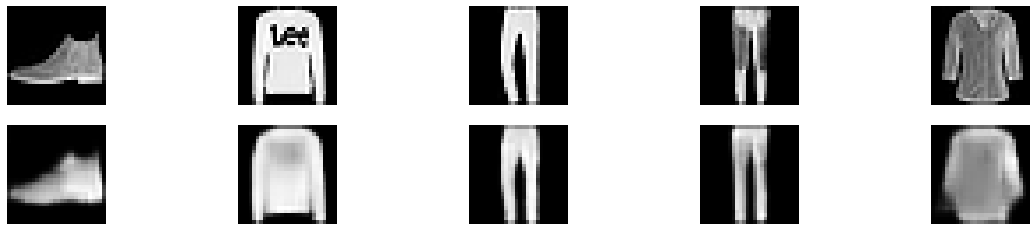

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Exercise 2

## Deep CNN

In [7]:
# ========================
#  Data Munging/Reshaping
# ========================
# Load pre-shuffled fashion MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Declaring a depth of 1 for MNIST
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

# Setting up calues as float32s that are bounded between 0 and 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Processing class labels they are currently a numeric vector
# ----> we need to transform them into categories
print (y_train.shape)
print (y_train[:10])

# We do this through one-hot encoding
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
# Check the shape
print(Y_train.shape)

(60000,)
[9 0 0 3 0 2 7 2 5 5]
(60000, 10)


Then, we set up our Deep CNN architecture. We first add a 2D convolutional layer with filters depth 16, kernel_size (2,2), strides (1,1), activation function 'relu' and padding method 'valid'. Then we add another 2D convolutional layer with filters depth 16, kernel_size (3,3), strides (1,1), activation function 'relu' and padding method 'valid'. Next, we Apply MaxPooling2D with pool_size (2,2) and Dropout(0.25). What's more, we flatten all our parameters and add a Dence layer of size 64 with activation function 'relu'. Finally, we add a dropout layer and generate a final output layer of size 10 for the 10 class classification problem.

In [8]:
# =============================
#  Setting up the Architecture
# ============================
# Declaring sequential model
model = Sequential()
# CNN input layer: input_shape: (depth,width,height)
# CNN convolution: number of filters, height and width of kernel
model.add(Conv2D(filters = 16,kernel_size=(2, 2), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))
# Notice here the the first entry output is none
print(model.output_shape)

# Next we add the remaining layers
model.add(Conv2D(filters = 16,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Setting up the fully connected lauer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
print (model.summary())

(None, 27, 27, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 27, 27, 16)        80        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                147520    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0 

In [9]:
# =====================
#  Compiling the model
# =====================
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# ===================
# Fitting the model
# ===================
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.7079 - acc: 0.7491
Epoch 2/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.4560 - acc: 0.8377
Epoch 3/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.4106 - acc: 0.8540
Epoch 4/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.3808 - acc: 0.8638
Epoch 5/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.3591 - acc: 0.8717
Epoch 6/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.3446 - acc: 0.8762
Epoch 7/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.3283 - acc: 0.8817
Epoch 8/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.3153 - acc: 0.8868
Epoch 9/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.3056 - acc: 0.8902
Epoch 10/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.2957 - acc: 0.892

In [10]:
# =====================
#  Evaluating the model
# =====================
model.evaluate(X_test, Y_test)

10000/10000 [==============================] - 1s 86us/step


[0.25667745584249496, 0.9104]

From above, we could see that the training error after the 10 epoches is 0.8924. The test error is 0.9104 which could show that it is a pretty good model. The accuracy is almost 1 for the 10 class classification problem.

## Transfer learning

In [0]:
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import tensorflow as tf

def grayscale_to_rgb(images, channel_axis=-1):
    images= K.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images= K.tile(images, tiling)
    return images
 
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Declaring a depth of 1 for MNIST
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# tranfer the greyscale data to rgb and (28,28,3) images to (32,32,3)
x_train = grayscale_to_rgb(X_train)
x_train = tf.image.resize_images(x_train, [32, 32])

x_test = grayscale_to_rgb(X_test)
x_test = tf.image.resize_images(x_test, [32, 32])

sess = tf.Session()
x_train = sess.run(x_train)
x_test= sess.run(x_test)

In [0]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))

In [21]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 14,752,330
Trainable params: 14,752,330
Non-trainable params: 0
_________________________________________________________________


In [22]:
conv_base.trainable = False
model.trainable_weights

[<tf.Variable 'dense_6/kernel:0' shape=(512, 64) dtype=float32_ref>,
 <tf.Variable 'dense_6/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_7/kernel:0' shape=(64, 64) dtype=float32_ref>,
 <tf.Variable 'dense_7/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_8/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'dense_8/bias:0' shape=(10,) dtype=float32_ref>]

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4),metrics=["acc"])

In [24]:
model.fit(x_train, Y_train, epochs=10, batch_size = 128)

Epoch 1/10
60000/60000 [==============================] - 19s 317us/step - loss: 1.6070 - acc: 0.3259
Epoch 2/10
60000/60000 [==============================] - 19s 310us/step - loss: 0.9047 - acc: 0.5956
Epoch 3/10
60000/60000 [==============================] - 19s 311us/step - loss: 0.7287 - acc: 0.7279
Epoch 4/10
60000/60000 [==============================] - 19s 313us/step - loss: 0.6264 - acc: 0.7828
Epoch 5/10
60000/60000 [==============================] - 19s 316us/step - loss: 0.5696 - acc: 0.8015
Epoch 6/10
60000/60000 [==============================] - 19s 317us/step - loss: 0.5306 - acc: 0.8140
Epoch 7/10
60000/60000 [==============================] - 19s 315us/step - loss: 0.5016 - acc: 0.8226
Epoch 8/10
60000/60000 [==============================] - 19s 314us/step - loss: 0.4787 - acc: 0.8303
Epoch 9/10
60000/60000 [==============================] - 19s 314us/step - loss: 0.4594 - acc: 0.8358
Epoch 10/10
60000/60000 [==============================] - 19s 314us/step - loss: 

In [25]:
model.evaluate(x_test, Y_test)

10000/10000 [==============================] - 6s 602us/step


[0.5297972127676011, 0.8231]

From above, we could see that the training error after the 10 epoches is 0.8407. The test error is 0.8231 which could show that it is a good model. However, it is not as good as the Deep CNN model.

# Exercise 3

In [0]:
import urllib
import pandas as pd

# load the data
link1 = "https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt"
link2 = 'https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt'
f = urllib.request.urlopen(link1)
g = urllib.request.urlopen(link2)

# clean the comment, for example, # GOOGLE
benign = f.readlines()
benign = [i[:-1] for i in benign if 35 not in i]
benign_label = list(np.repeat(0,len(benign)))
malicious = g.readlines()
malicious = [i[:-1] for i in malicious]
malicious_label = list(np.repeat(1,len(malicious)))
url_text = benign+malicious
label = benign_label + malicious_label


In [27]:
# create a dataframe for the url and label
# 0 represent the benigh
# 1 represent the malicious
url = pd.DataFrame({'url':url_text, 'label': label})
url.head(5)

,label,url
0,0,b'.0.blogger.gmodules.com'
1,0,b'.0.client-channel.google.com'
2,0,b'.0.docs.google.com'
3,0,b'.0.drive.google.com'
4,0,b'.0.gvt0.cn'


In [0]:
# convert the bytes type url to numerical using one-hot encoding
sample = []
for i in url['url']:
    temp = []
    for j in i:
        temp.append(j)
    sample.append(temp)
      

## RNN

In [0]:
from keras.preprocessing import sequence
# --- Setting up constants ---
# Number of words as features, we keep only the top most-common words
max_features = 10000
# Max number of words in comments (truncate the rest)
max_len = 24 # If not set here, will use the max comment length which is 1132



In [0]:
# split the training set and test set
from sklearn.model_selection import train_test_split
x = sequence.pad_sequences(sample, maxlen = max_len)
y = y_train = url['label']

x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)


y_train = np_utils.to_categorical(Y_train, 2)
y_test = np_utils.to_categorical(Y_test, 2)

In [31]:
# print hte x_train
x_train[0]

array([ 46,  97, 105, 100, 109, 112,  48,  52,  48,  50,  46, 117, 115,
        46, 111, 114,  97,  99, 108, 101,  46,  99, 111, 109], dtype=int32)

In [32]:
# --- Training model: Embedding + RNN ---
model = Sequential()
model.add(Embedding(max_features, max_len))
model.add(LSTM(32))
model.add(Dense(2, activation ='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 24)          240000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                7296      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 247,362
Trainable params: 247,362
Non-trainable params: 0
_________________________________________________________________


In [33]:
# --- Compile Model ---
#Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs = 10, batch_size = 64, 
                    validation_split = 0.2,verbose=1)

Train on 36078 samples, validate on 9020 samples
Epoch 1/10
36078/36078 [==============================] - 38s 1ms/step - loss: 0.0838 - acc: 0.9799 - val_loss: 0.0564 - val_acc: 0.9800
Epoch 2/10
36078/36078 [==============================] - 36s 1ms/step - loss: 0.0482 - acc: 0.9808 - val_loss: 0.0411 - val_acc: 0.9802
Epoch 3/10
36078/36078 [==============================] - 36s 999us/step - loss: 0.0348 - acc: 0.9843 - val_loss: 0.0284 - val_acc: 0.9879
Epoch 4/10
36078/36078 [==============================] - 36s 998us/step - loss: 0.0303 - acc: 0.9869 - val_loss: 0.0259 - val_acc: 0.9882
Epoch 5/10
36078/36078 [==============================] - 37s 1ms/step - loss: 0.0282 - acc: 0.9871 - val_loss: 0.0241 - val_acc: 0.9894
Epoch 6/10
36078/36078 [==============================] - 37s 1ms/step - loss: 0.0271 - acc: 0.9876 - val_loss: 0.0251 - val_acc: 0.9886
Epoch 7/10
36078/36078 [==============================] - 36s 1ms/step - loss: 0.0268 - acc: 0.9878 - val_loss: 0.0255 - val_

In [35]:
# evaluate for the test set
model.evaluate(x_test, y_test)

22213/22213 [==============================] - 11s 491us/step


[0.023060434805201424, 0.9883176518255076]

## CNN

In [36]:
## CNN
# --- Setting up a Sigmoid Sequential Model ---
# Initialize model
model_conv = Sequential()
model_conv.add(Embedding(10000,100, input_length=24))
model_conv.add(Conv1D(64, 2, activation='relu'))
model_conv.add(Conv1D(64, 3, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Flatten())
model_conv.add(Dense(2, activation='softmax'))
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 64)            12864     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 642       
Total params: 1,025,858
Trainable params: 1,025,858
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_conv.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [38]:
model_conv.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 64,validation_split = 0.2)

scores = model_conv.evaluate(x_test, y_test) 
print("%s: %.2f%%" % (model_conv.metrics_names[1], scores[1]*100))

Train on 36078 samples, validate on 9020 samples
Epoch 1/10
36078/36078 [==============================] - 5s 147us/step - loss: 0.0457 - acc: 0.9835 - val_loss: 0.0245 - val_acc: 0.9859
Epoch 2/10
36078/36078 [==============================] - 5s 131us/step - loss: 0.0226 - acc: 0.9891 - val_loss: 0.0200 - val_acc: 0.9901
Epoch 3/10
36078/36078 [==============================] - 5s 131us/step - loss: 0.0198 - acc: 0.9915 - val_loss: 0.0204 - val_acc: 0.9894
Epoch 4/10
36078/36078 [==============================] - 5s 132us/step - loss: 0.0176 - acc: 0.9920 - val_loss: 0.0204 - val_acc: 0.9907
Epoch 5/10
36078/36078 [==============================] - 5s 131us/step - loss: 0.0161 - acc: 0.9939 - val_loss: 0.0198 - val_acc: 0.9918
Epoch 6/10
36078/36078 [==============================] - 5s 133us/step - loss: 0.0145 - acc: 0.9937 - val_loss: 0.0201 - val_acc: 0.9908
Epoch 7/10
36078/36078 [==============================] - 5s 133us/step - loss: 0.0130 - acc: 0.9950 - val_loss: 0.0268 - v

In [39]:
# test accuracy
print("%s: %.2f%%" % (model_conv.metrics_names[1], scores[1]*100))

acc: 99.14%


## Compare the two methods

### RNN and CNN

In [0]:
from sklearn.metrics import roc_curve
y_pred_rnn =model.predict(x_test)
y_pred_cnn =model_conv.predict(x_test)
# convert the categorical 2D to 1D dimension for y_prediction
Y_pred_rnn = []
Y_pred_cnn = []
for i in y_pred_rnn:
  if i[0] >= i[1]:
    Y_pred_rnn.append(0)
  else:
    Y_pred_rnn.append(1)

for i in y_pred_cnn:
  if i[0] >= i[1]:
    Y_pred_cnn.append(0)
  else:
    Y_pred_cnn.append(1)    
fpr_rnn, tpr_rnn, thresholds_r = roc_curve(Y_test, Y_pred_rnn)
fpr_cnn, tpr_cnn, thresholds_c = roc_curve(Y_test, Y_pred_cnn)

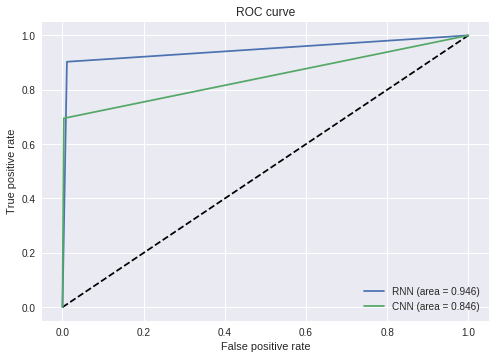

In [0]:
# auc
from sklearn.metrics import auc
auc_rnn = auc(fpr_rnn, tpr_rnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

From the ROC curve, we could see that the RNN is better than CNN since the area under the curve is larger for RNN.